### Import Libraries 

In [16]:
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.decomposition import TruncatedSVD

import joblib

import warnings
warnings.filterwarnings('ignore')

### Load the Dataset and Add headers

In [17]:
data = pd.read_csv('Datasets/Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_May19.csv', usecols=['name', 'asins', 'reviews.rating', 'reviews.username'], encoding='utf8')
data.columns = ['product_name', 'product_id', 'rating', 'user']
data

,product_name,product_id,rating,user
0,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",3,Byger yang
1,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",4,ByMG
2,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",5,BySharon Lambert
3,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",5,Bymark sexson
4,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",5,Bylinda
...,...,...,...,...
28327,"Fire HD 8 Tablet with Alexa, 8 HD Display, 16 ...",B018T075DC,5,Mom2twinsplus1
28328,"Fire HD 8 Tablet with Alexa, 8 HD Display, 16 ...",B018T075DC,4,fireman21
28329,"Fire HD 8 Tablet with Alexa, 8 HD Display, 16 ...",B018T075DC,5,suzannalicious
28330,"Fire HD 8 Tablet with Alexa, 8 HD Display, 16 ...",B018T075DC,5,SandyJ


### Data Statistics

#### Handling Missing Data

In [18]:
print('Number of missing values across columns: \n', data.isnull().sum())

data = data.dropna()
print('\nNumber of missing values across columns: \n', data.isnull().sum())

Number of missing values across columns: 
 product_name    0
product_id      0
rating          0
user            5
dtype: int64

Number of missing values across columns: 
 product_name    0
product_id      0
rating          0
user            0
dtype: int64


#### Statistics

In [19]:
print(f"Total no of ratings: {data.shape[0]}")
print(f"Total No of Users: {len(pd.unique(data.user))}")
print(f"Total No of products: {len(pd.unique(data.product_id))}")

Total no of ratings: 28327
Total No of Users: 16268
Total No of products: 65


In [20]:
data.describe()['rating'].T


count    28327.000000
mean         4.514068
std          0.934903
min          1.000000
25%          4.000000
50%          5.000000
75%          5.000000
max          5.000000
Name: rating, dtype: float64

### Ratings Summary

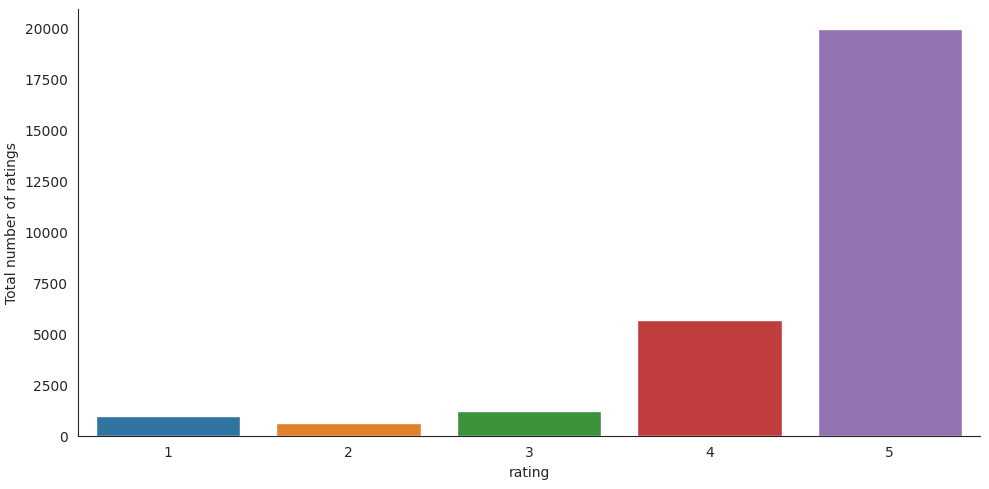

In [21]:
with sns.axes_style('white'):
    g = sns.catplot(x="rating", data=data, aspect=2.0,kind='count')
    g.set_ylabels("Total number of ratings")

### Collaborative Filtering Recommendation System

### Ratings Matrix

In [22]:
product_user_ratings = data.pivot_table(values='rating', index='product_id', columns='user', fill_value=0)
product_user_ratings.head()

user,000G,00Gambler,1000011,10100915,1029cr,1098,118001,1191946,11bee,1215,...,zRoyals,zackeemom,zane1222,zedog83,zeke,zerosky,zetyk,ziggy24,zmax192,ztlbxx
product_id,,,,,,,,,,,,,,,,,,,,,
"B0002LCUZK,B010CEC6MI,B01B25NN64",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
B001NIZB5M,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
B005OOKNP4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
B006BGZJJ4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
B006GWO7UA,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [23]:
product_data = data[['product_name', 'product_id']].drop_duplicates(ignore_index=True)
product_data.columns = ['name', 'id']

### Utility Data Structures

##### Mapping from Product ID to Product Name

In [24]:
product_id_name = product_data.set_index('id')
product_id_name = product_id_name.to_dict(orient='index')

{k: product_id_name[k] for k in list(product_id_name.keys())[:5]}

{'B00QWO9P0O,B00LH3DMUO': {'name': 'AmazonBasics AAA Performance Alkaline Batteries (36 Count)'},
 'B00DIHVMEA,B00EZ1ZTV0': {'name': 'AmazonBasics Nylon CD/DVD Binder (400 Capacity)'},
 'B01E6AO69U,B00L9EPT8O': {'name': 'Amazon Echo ‚Äì White'},
 'B01J24C0TI': {'name': 'Amazon Echo Show - Black'},
 'B073SQYXTW': {'name': 'Echo Spot Pair Kit (Black)'}}

##### Mapping from Product Name to Product ID

In [25]:
product_name_id = product_data.set_index('name')
product_name_id = product_name_id.to_dict(orient='index')

{k: product_name_id[k] for k in list(product_name_id.keys())[:5]}

{'AmazonBasics AAA Performance Alkaline Batteries (36 Count)': {'id': 'B00QWO9P0O,B00LH3DMUO'},
 'AmazonBasics Nylon CD/DVD Binder (400 Capacity)': {'id': 'B00DIHVMEA,B00EZ1ZTV0'},
 'Amazon Echo ‚Äì White': {'id': 'B01E6AO69U,B00L9EPT8O'},
 'Amazon Echo Show - Black': {'id': 'B01J24C0TI'},
 'Echo Spot Pair Kit (Black)': {'id': 'B073SQYXTW'}}

##### Product IDs according to order of the Ratings Matrix

In [26]:
product_ids = list(product_user_ratings.index)
product_ids[:5]

['B0002LCUZK,B010CEC6MI,B01B25NN64',
 'B001NIZB5M',
 'B005OOKNP4',
 'B006BGZJJ4',
 'B006GWO7UA']

### Generate Correlation Matrix using Truncated SVD

In [27]:
svd = TruncatedSVD(n_components=10)
decomposed_matrix = svd.fit_transform(product_user_ratings)
correlation_matrix = np.corrcoef(decomposed_matrix)
correlation_matrix

array([[ 1.        ,  0.31908137, -0.99542183, ..., -0.27299795,
        -0.26846796,  0.57129568],
       [ 0.31908137,  1.        , -0.33189662, ...,  0.4202831 ,
         0.54837485, -0.11787916],
       [-0.99542183, -0.33189662,  1.        , ...,  0.32520959,
         0.30660459, -0.54810334],
       ...,
       [-0.27299795,  0.4202831 ,  0.32520959, ...,  1.        ,
         0.96130291, -0.33966684],
       [-0.26846796,  0.54837485,  0.30660459, ...,  0.96130291,
         1.        , -0.44970679],
       [ 0.57129568, -0.11787916, -0.54810334, ..., -0.33966684,
        -0.44970679,  1.        ]])

#### Recommendation Function

In [28]:
def show_recommended_products(product_name, product_count=15):
    # Getting product index from name
    product_id = product_name_id[product_name]['id']
    i = product_ids.index(product_id)

    # Correlation coefficients of the product
    coefs = correlation_matrix[i]

    # Collecting data of the products
    rec_ids, rec_coeffs, rec_names = [], [], []
    for i, coef in enumerate(coefs):
        if product_user_ratings.index[i] != product_id:
            rec_ids.append(product_user_ratings.index[i])
            rec_coeffs.append(coef)
            rec_names.append(product_id_name[product_user_ratings.index[i]]['name'])
    related_products_info = {'product_id': rec_ids, 'product_name': rec_names, 'correlation_coefficient': rec_coeffs}
    related_products_df = pd.DataFrame(related_products_info)

    # Sorting recommendations on the basis of coefficients      
    related_products_df = related_products_df.sort_values(by='correlation_coefficient', ascending=False)
    recommended_products_df = related_products_df.iloc[:product_count]
    
    return recommended_products_df

#### Demonstration

In [29]:
show_recommended_products('Echo Dot (Previous generation)')

,product_id,product_name,correlation_coefficient
11,B00IOY8XWQ,"Kindle Voyage E-reader, 6 High-Resolution Disp...",0.879527
48,B01GAGYVU2,Certified Refurbished Amazon Echo,0.794186
22,B00VINDBJK,Kindle Oasis E-reader with Leather Charging Co...,0.765113
5,B006LW0W5Y,AmazonBasics 16-Gauge Speaker Wire - 100 Feet,0.748736
20,B00REQKWGA,Kindle Oasis E-reader with Leather Charging Co...,0.726771
26,B00ZS0G0PG,Kindle Oasis E-reader with Leather Charging Co...,0.723863
10,"B00F5CKWBA,B00KPQCWAU",AmazonBasics External Hard Drive Case,0.711281
56,B01L7XWEQQ,AmazonBasics Silicone Hot Handle Cover/Holder ...,0.690595
2,B005OOKNP4,AmazonBasics Bluetooth Keyboard for Android De...,0.669631
58,B06XCWLL12,All-New Kindle Oasis E-reader - 7 High-Resolut...,0.644734


#### Saving Correlation Matrix

In [30]:
joblib.dump(correlation_matrix, 'Outputs/Collaborative Filtering Correlation Matrix.csv')
joblib.dump(product_ids, 'Outputs/Collaborative Filtering Product Ids.csv')
joblib.dump(product_name_id, 'Outputs/Collaborative Filtering Product Id Mapping.csv')
joblib.dump(product_id_name, 'Outputs/Collaborative Filtering Id Product Mapping.csv')

['Outputs/Collaborative Filtering Id Product Mapping.csv']